In [ ]:
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.stats import RipleysKEstimator

def ripleys_import(replicate_number, folder_name, mutant_name, treatment_name, second_experiment):
    """Imports replicates of the cell locations for analysis by Ripley's K function"""
    reps = []
    if second_experiment:
        for replicate in range(1, replicate_number + 1):
            file = pd.read_csv("msresist/data/Phenotypic_data/Distances/" + folder_name + "/" + mutant_name + "_" + treatment_name +"_TR" + str(replicate) + ".csv", header=None)
            points = file.values
            reps.append(points)
    else:
        for replicate in range(1, replicate_number + 1):
            if replicate != 1:
                file = pd.read_csv("msresist/data/Phenotypic_data/Distances/" + folder_name + "/Results_" + mutant_name + treatment_name + str(replicate) + ".csv")
            else:
                file = pd.read_csv("msresist/data/Phenotypic_data/Distances/" + folder_name + "/Results_" + mutant_name + treatment_name + ".csv")
            points = file.loc[:, "X":"Y"].values
            reps.append(points)
    return reps


In [1]:
def PlotRipleysK(folder, mutant, treatments, replicates, ax, title=False, second_experiment=False):
    """Plots the Ripley's K Estimate in comparison to the Poisson for a range of radii"""
    Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)
    r = np.linspace(0, 5, 51)
    r_for_df = r
    poisson = Kest.poisson(r)
    poisson_for_df = poisson
    # Done n times to create total of n+1 to match n+1 replicates
    for _ in range(replicates-1):
        poisson_for_df = np.hstack((poisson_for_df, poisson))
        r_for_df = np.hstack((r_for_df, r))
    data = np.vstack((r_for_df, poisson_for_df))
    for treatment in treatments:
        reps = ripleys_import(replicates, folder, mutant, treatment, second_experiment)
        treat_array = treat_array_func(reps, Kest, r, poisson)
        data = np.vstack((data, treat_array))
    df = pd.DataFrame(data).T
    if mutant == 'C6':
        df.columns = ["Radii", "Poisson", "Untreated", "Erlotinib", "AF154 + Erlotinib", "5uM Erlotinib", "AF154 + 5uM Erlotinib"]
    else:
        df.columns = ["Radii", "Poisson", "Untreated", "Erlotinib", "AF154 + Erlotinib"]
    df = pd.melt(df, ["Radii"])
    df.columns = ["Radii", "Condition", "K Estimate"]
    sns.lineplot(x="Radii", y="K Estimate", hue="Condition", data=df, ci=68, ax=ax)
    ax.legend(prop={'size': 8})
    if title:
        ax.set_title(title)
    else:
        ax.set_title(mutant)

In [ ]:
def BarPlotRipleysK(ax, folder, mutants, xticklabels, treatments, legendlabels, replicates, r, colors, TreatmentFC=False, ylabel=False, second_experiment=False):
    """Plots a bar graph of the Ripley's K Estimate values for all mutants and conditions in comparison to the Poisson at a discrete radius.
    Note that radius needs to be input as a 1D array for the RipleysKEstimator to work"""
    Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)
    poisson = Kest.poisson(r)
    mutant_dfs = []
    for z, mutant in enumerate(mutants):
        if mutant == 'C6':
            treatments = ['UT', 'E5', 'EA']
        for j, treatment in enumerate(treatments):
            reps = ripleys_import(replicates, folder, mutant, treatment, second_experiment)
            treat_array = treat_array_func(reps, Kest, r, poisson, Kestbool=True)
            df = pd.DataFrame(treat_array)
            df.columns = ["K Estimate"]
            if second_experiment:
                df["Cell Line"] = xticklabels[z]
            else:
                df["AXL mutants Y->F"] = xticklabels[z]
            df["Treatment"] = legendlabels[j]
            mutant_dfs.append(df)
    df = pd.concat(mutant_dfs)

    if TreatmentFC:
        ut = df[df["Treatment"].str.contains("Untreated")]
        af = df[df["Treatment"].str.contains("AF154")]
        e = df[df["Treatment"].str.contains("Erlotinib")]["K Estimate"]
        ut["K Estimate"] /= e
        af["K Estimate"] /= e
        df = pd.concat([ut, af])
        ax.axhline(1, ls='--', label="Erlotinib", color="red", linewidth=1)

    pal = sns.xkcd_palette(colors)
    if second_experiment:
        sns.barplot(x="Cell Line", y="K Estimate", hue="Treatment", data=df, ci=68, palette=pal, ax=ax, **{"linewidth": 0.5}, **{"edgecolor": "black"})
    else:
        sns.barplot(x="AXL mutants Y->F", y="K Estimate", hue="Treatment", data=df, ci=68, palette=pal, ax=ax, **{"linewidth": 0.5}, **{"edgecolor": "black"})
    ax.set_title("Island effect")
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.legend(prop={'size': 8})

    if ylabel:
        ax.set_ylabel(ylabel)

In [22]:
"""
This creates a new figure for the clustering ripley's k data
"""

import matplotlib
import numpy as np
import seaborn as sns
from msresist.figures.common import subplotLabel, getSetup, IndividualTimeCourses, import_phenotype_data, barplot_UtErlAF154
from msresist.distances import treat_array_func

def makeFigure():
    """Get a list of the axis objects and create a figure"""
    # Get list of axis objects
    ax, f = getSetup((12, 4), (1, 5), multz={0: 1})

    # Add subplot labels
    subplotLabel(ax)

    # Set plotting format
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})


    # Labels
    treats = ["Untreated", "Erlotinib", "Erl + AF154"]
    colors = ["white", "windows blue", "scarlet"]
    new_lines = ['WT', 'KO', 'Calu-6']
    new_mutants = ['WT', 'KO', 'C6']
    new_treatments = [['UT', 'E', 'EA'], ['UT', 'E', 'EA'], ['UT', 'E', 'EA', 'E5', "E5A"]]
    
    # Time courses
    for i, line in enumerate(new_lines):
        PlotRipleysK('Clustering_48hrs', new_mutants[i], new_treatments[i], 4, ax=ax[i+1], title=line, second_experiment=True)
    

    # Bar plots
    BarPlotRipleysK(ax[0], 'Clustering_48hrs', new_mutants, new_lines, new_treatments[0], treats, 4, np.linspace(1.5, 14.67, 1), colors, TreatmentFC="Erlotinib", ylabel="fold-change K estimate", second_experiment=True)

    return f


/var/folders/0c/6y629b5n42qdt1g8yn1nxjqh0000gn/T/ipykernel_33130/2641860855.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ut["K Estimate"] /= e
/var/folders/0c/6y629b5n42qdt1g8yn1nxjqh0000gn/T/ipykernel_33130/2641860855.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af["K Estimate"] /= e


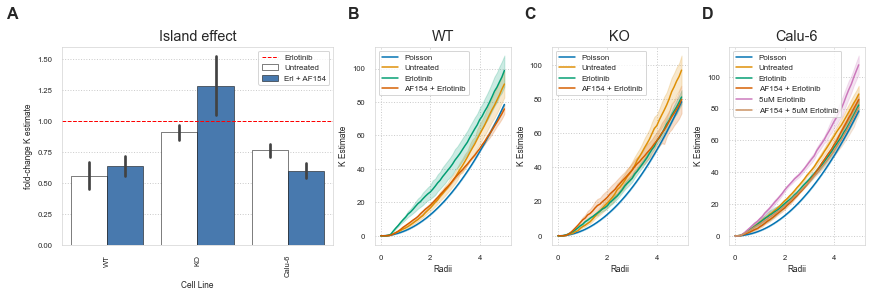

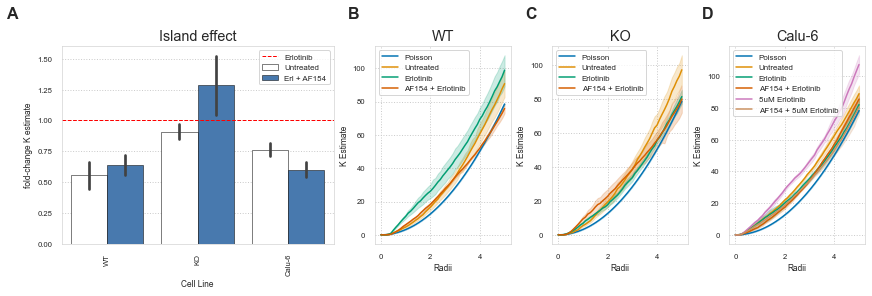

In [23]:
makeFigure()



In [143]:
from msresist.pre_processing import FixColumnLabels

def import_phenotype_data(phenotype="Cell Viability", merge=True):
    """Import all bioreplicates of a specific phenotype"""
    if phenotype == "Cell Viability":
        cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
        cv2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv")
        cv3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv")
        cv4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR4_Phase.csv")
        res = FixColumnLabels([cv1, cv2, cv3, cv4])

    elif phenotype == "Cell Death":
        red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
        red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
        red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
        red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
        red4.columns = red3.columns
        res = FixColumnLabels([red1, red2, red3, red4])
        res = normalize_cellsDead_to_cellsAlive(res)

    elif phenotype == "Migration":
        sw2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
        sw3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
        sw4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")
        res = fix_migration_columns(sw2, sw3, sw4)

    elif phenotype == "Island":
        res = DataFrameRipleysK('48hrs', mutants, ['ut', 'e', 'ae'], 6, np.linspace(1, 14.67, 1)).reset_index().set_index("Mutant")
        res.columns = ["Treatment", "Island"]
    
    elif phenotype == "Clustering Phase":
        res = [pd.read_csv("msresist/data/Phenotypic_data/Summer_2022/Clustering_Multiple_viability.csv")]
         
        
    elif phenotype == "Clustering Death":
        res = [pd.read_csv("msresist/data/Phenotypic_data/Summer_2022/Clustering_Multiple_viability_redconf.csv")]
        cv = import_phenotype_data("Clustering Phase")
        for jj in range(1, res[0].columns.size):
            res[0].iloc[:, jj] /= cv[0].iloc[:, jj]

    return res

In [190]:
#New function version, for plot_clustering_viability
from matplotlib import gridspec, pyplot as plt
def plot_clustering_data(ds, TimePointFC, line, value_name, plot_type, ylim, ax_, colors, title):
    if plot_type == "Time Course":
        for d in ds:
            if TimePointFC:
                d = TimePointFoldChange(d, TimePointFC)

            elapsed = ds[0].iloc[:, 0]
            ds = ds[0].iloc[12:, :]
            ds = pd.melt(ds, id_vars=["Elapsed"], value_name=value_name)
            ds["Lines"] = [s.split("-")[0] for s in ds["variable"]]
            ds["Treatment"] = [s.split(".")[0] for s in [s.split("-")[1] for s in ds["variable"]]]
            ds = ds.drop("variable", axis=1)
            x = ds[ds["Lines"] == line]
            sns.lineplot(x="Elapsed", y=value_name, hue="Treatment", data=x, err_style="bars", ci=68, ax=ax_)
            ax_.set_title(line)
            ax_.set_ylabel(value_name)
            ax_.legend(prop={'size': 8})
            ax_.set_ylim(ylim)
    else:
        for d in ds:
            if TimePointFC:
                d = TimePointFoldChange(d, TimePointFC)
        ds = ds[0]
        ds = pd.DataFrame(ds.iloc[36, 1:]).reset_index()
        ds.columns = ["index", "fold-change confluency"]
        ds["Lines"] = [s.split("-")[0] for s in ds["index"]]
        ds["Treatment"] = [s.split(".")[0] for s in [s.split("-")[1] for s in ds["index"]]]
        ds = ds.drop("index", axis=1)
        pal = sns.xkcd_palette(colors)


        ax = sns.barplot(
            x="Lines", y="fold-change confluency", hue="Treatment", data=ds, ax=ax_, ci=68, palette=pal, **{"linewidth": 0.5}, **{"edgecolor": "black"}
        )

        ax.set_title(title)
        ax.legend(prop={'size': 6})

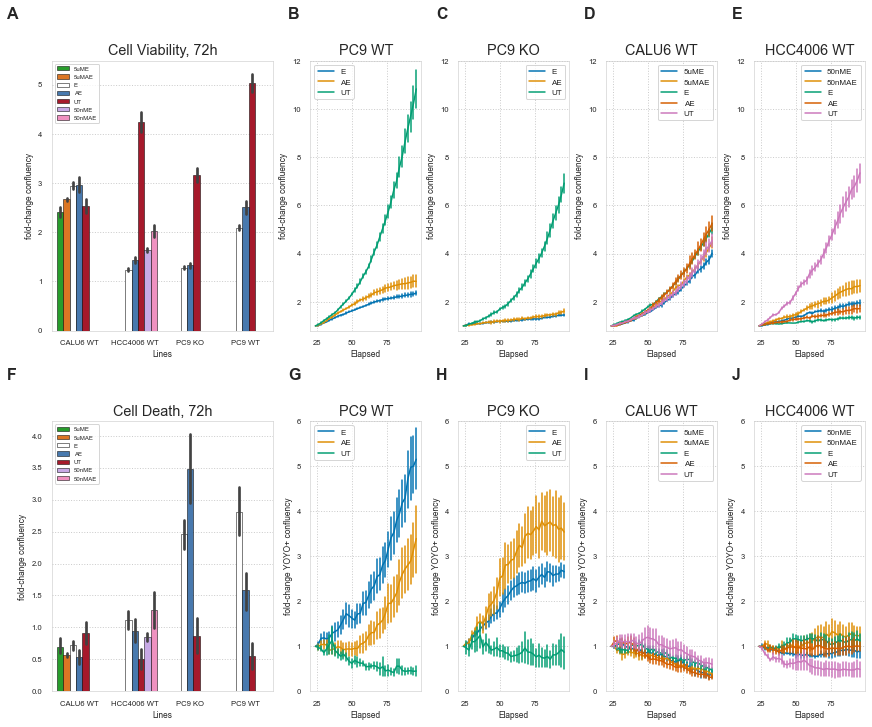

In [192]:
ax, f = getSetup((12, 10), (2, 6), multz={0: 1, 6: 1})

# Add subplot labels
subplotLabel(ax)

# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

 

ds = import_phenotype_data(phenotype="Clustering Phase")
red = import_phenotype_data(phenotype = "Clustering Death")
TimePointFC = 24
lines = ["PC9 WT", "PC9 KO", "CALU6 WT", "HCC4006 WT"]
ylim_phase = [.8, 12]
ylim_yoyo = [0, 6]
colors = ["green", "orange", "white", "windows blue", "scarlet", "lavender", "pink"]
title1 = "Cell Viability, 72h"
title2 = "Cell Death, 72h"

plot_clustering_data(ds, TimePointFC, line, "fold-change confluency", "Barplot", ylim_phase, ax[0], colors, title1)
plot_clustering_data(red, TimePointFC, line, "fold-change YOYO+ confluency", "Barplot", ylim_yoyo, ax[5], colors, title2)

for i, line in enumerate(lines):
    plot_clustering_data(ds, TimePointFC, line, "fold-change confluency", "Time Course", ylim_phase, ax[i+1], colors, title1)
    plot_clustering_data(red, TimePointFC, line, "fold-change YOYO+ confluency", "Time Course", ylim_yoyo, ax[i+6], colors, title2)